# An analytic theory of shallow networks dynamics for hinge loss classification

This code can reproduce all the results reported in the paper.

Libraries required: numpy, scipy, tensorflow (version 1.xx), matplotlib.

Options are provided as used in the paper (some quantities are downsampled to ensure short runtimes), or can be modified to experiment.

In [1]:
# Importing the required libraries
%matplotlib inline
import numpy as np
from scipy import special
#%tensorflow_version 1.x
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

TensorFlow 1.x selected.


## Creating the dataset

Please choose your dataset:

1.   Gaussian data (choose train/validation size $N$, dimensionality $d$ and mislabeling error $\delta$)
2.   MNIST data (choose train/validation size. This requires MNIST files: please download from http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz and http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz, extract and place in folder MNIST, or change path as needed. MNIST data is for parameter visualization only, since our estimates do not apply in this case.)



In [2]:
# Creating dataset
DATA_TYPE = 1

if DATA_TYPE == 1:
  # Parameters
  TRAIN_SIZE = 10000  # Size of training set
  TEST_SIZE = 10000  # Size of validation set
  dd = 100   # Dimensionality of the dataset
  ErrRatio = 0.0  # Fraction of mislabeled training examples

  # Creating dataset, reference vector and labels
  train_set_x = np.random.normal(0,1,(TRAIN_SIZE,dd))
  test_set_x = np.random.normal(0,1,(TEST_SIZE,dd))
  w_ref = np.random.normal(0,1,(dd,1))
  w_ref = w_ref/np.linalg.norm(w_ref)
  train_set_p = np.sign(train_set_x@w_ref)[:,0]
  test_set_p = np.sign(test_set_x@w_ref)[:,0]
  # Mislabeling
  if ErrRatio > 0.0:
    ERR_SIZE = int(TRAIN_SIZE*ErrRatio)
    einds = np.random.choice(TEST_SIZE,ERR_SIZE)
    train_set_p[einds] *= -1
  print("Gaussian dataset created.")

if DATA_TYPE == 2:
  # Variables
  TRAIN_SIZE = 10000  # Size of training set
  TEST_SIZE = 10000  # Size of validation set
  dd = 28*28  # Fixed for MNIST
  
  # Loading files
  train_labels_bf = open("MNIST/train-labels.idx1-ubyte", "rb")
  train_labels_all = np.fromfile(train_labels_bf, dtype=np.uint8)[8:]
  train_images_bf = open("MNIST/train-images.idx3-ubyte", "rb")
  train_images_all = np.reshape(np.fromfile(train_images_bf, dtype=np.uint8)[16:],[-1,dd])

  # Creating balanced datasets
  pos_labels = np.where(train_labels_all%2==0)[0]
  neg_labels = np.where(train_labels_all%2==1)[0]
  train_lab = np.concatenate((pos_labels[:TRAIN_SIZE//2],neg_labels[:TRAIN_SIZE//2]))
  np.random.shuffle(train_lab)
  test_lab = np.concatenate((pos_labels[TRAIN_SIZE//2:TRAIN_SIZE//2+TEST_SIZE//2],neg_labels[TRAIN_SIZE//2:TRAIN_SIZE//2+TEST_SIZE//2]))
  np.random.shuffle(test_lab)
  train_set_x = np.asarray(train_images_all[train_lab], dtype=np.float32)/255.0
  train_set_y = train_labels_all[train_lab]
  test_set_x = np.asarray(train_images_all[test_lab], dtype=np.float32)/255.0
  test_set_y = train_labels_all[test_lab]
  # Lables from parity
  train_set_p = 2.0*(0.5 - train_set_y%2)
  test_set_p = 2.0*(0.5 - test_set_y%2)
  # Reference vector is the difference of averages
  w_ref = np.mean(train_set_p[:,np.newaxis]*train_set_x, axis=0)
  w_ref = np.reshape(w_ref/np.linalg.norm(w_ref),[dd,1])
  print("MNIST dataset created.")

Gaussian dataset created.


## Training the model

Here we train the neural network.

Many parameters can be tweaked:

*   `steps`: number of GD steps
*   `HS`: hidden layer size ($M$ in the paper)
*   `lr`: learning rate ($\beta^*$ in the paper)
*   `alpha`: loss rescaling factor ($\alpha$ in the paper)
*   `h`: hinge threshold ($h$ in the paper)

Other code-specific parameters:

*   `act_each`: sampling rate (parameters, and outputs are saved each `act_each` steps. Set to a larger value to avoid running out of memory in long runs)

Please not that especially the learning rate should be heavily modified when changing `alpha` to obtain a meaningful training. You can refer to the paper for sample values.

A graph of training and validation is provided at the end of the run. With standard parameters this should be similar to Fig.3a from the paper.


Training step: 400/400
Final training error: 0.0
Final validation error: 0.0202


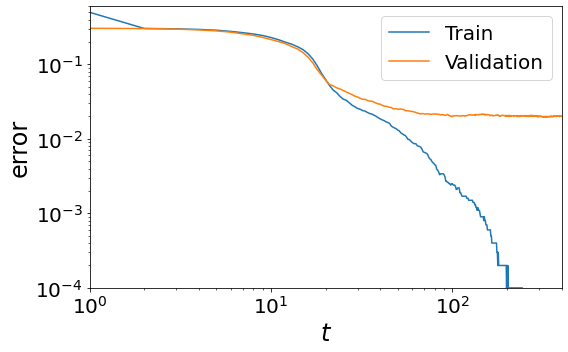

In [3]:
# Training parameters
steps = 400
HS = 400
lr = 1000.0
alpha = 1.0
h = 1.0
# Sampling
act_each = 1
act_num = int(np.ceil((steps+1)/act_each))

# Lists that will store outputs
s = []
te = []
ee = []
wei1 = []
ytrain1 = []

# Definition of the neural network
x = tf.placeholder(tf.float32, [None, dd])
y_ref = tf.placeholder(tf.float32, [None])
y_ = tf.placeholder(tf.float32, [None])
wl = []

W1 = tf.Variable(tf.random.normal([dd, HS], stddev=1.0))
wl.append(W1)
hl = tf.nn.relu(tf.matmul(x, W1/np.sqrt(dd)))
W2 = tf.Variable(tf.random.normal([HS, 1], stddev=1.0))
wl.append(W2)
y = tf.squeeze(tf.matmul(hl, W2/HS))
ydiff = y-y_ref
cost = tf.reduce_mean(tf.nn.relu(h-y_*alpha*(ydiff)))/alpha**2
train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
error = tf.reduce_mean(0.5*(1.0-tf.sign(y_*(y-y_ref))))

# Starting the training
with tf.Session() as sess:
  tf.global_variables_initializer().run()
  # Store predictions at initial time
  yref = sess.run(y, feed_dict={x: train_set_x})
  test_yref = sess.run(y, feed_dict={x: test_set_x})
  train_error = sess.run(error, feed_dict={x: train_set_x, y_: train_set_p, y_ref: yref})
  eval_error = sess.run(error, feed_dict={x: test_set_x, y_: test_set_p, y_ref: test_yref})
  # Main loop over steps
  for st in range(steps+1):
    # Save quantities at proper intervals
    if st%act_each==0:
      s.append(st)
      te.append(train_error)
      ee.append(eval_error)
      wei1.append(sess.run(wl, feed_dict={x: test_set_x}))
      ytrain1.append(sess.run(ydiff, feed_dict={x: train_set_x, y_ref: yref}))
    # Perform one step of GD
    train_error, _ = sess.run([error, train_step], feed_dict={x: train_set_x, y_: train_set_p, y_ref: yref})
    eval_error = sess.run(error, feed_dict={x: test_set_x, y_: test_set_p, y_ref: test_yref})
    # Simple counter
    print("\rTraining step: {}/{}".format(st,steps), end='')

# Print final values and plot graph
print("\nFinal training error: "+str(te[-1]))
print("Final validation error: "+str(ee[-1]))

fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,steps)
ax.set_ylim(1e-4,0.6)
ax.set_xlabel(r"$t$", fontsize=24)
ax.set_ylabel(r"error", fontsize=24)
ax.tick_params(labelsize=20)
ax.plot(s,te,'-',label="Train")
ax.plot(s,ee,'-',label="Validation")
ax.legend(fontsize=20)
plt.tight_layout()

## Parameters evolution

We want to plot the evolution of some parameters and compare to our model.

First, we load the parameters from the run and compute the "clock" function $\gamma(t)$ (see paper for definition, specifically Eq.(13) for function numerically integrated here). We also plot this quantity together with a numerical estimate, which should look like Fig.1c from the paper.

We then plot the evolution of $a(t)$, $w^\parallel(t)$ and $|w_\perp(t)|$ (see paper for definition) and our analytical estimate. 
For a standard case these figures should resemble Fig.1a and 1b and Fig.1 of the SM.

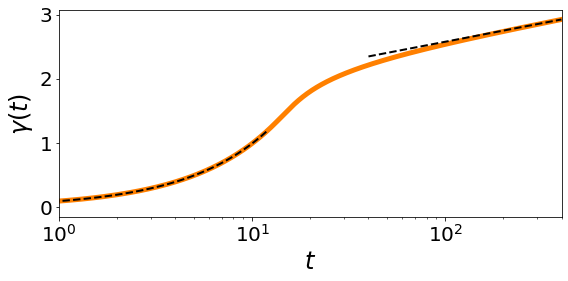

In [4]:
# Get all parameters and relevant projections
al = []
wl = []
wperpl = []
for ii in range(act_num):
  al.append(wei1[ii][1][:,0])
  w = wei1[ii][0]
  wp = np.sum(w*w_ref,axis=0)
  wl.append(wp)
  wperpl.append(np.sqrt(np.linalg.norm(w,axis=0)**2-wp**2))
a = np.asarray(al)
w = np.asarray(wl)
wperp = np.asarray(wperpl)

# Compute \gamma(t) for input parameters by integrating Eq.(13) from the paper
# Parameters:
eps = 1e-20   # Small numerical regularization
factor = 10  # How many timestep to use for a "training step", to increase until convergence

gll = [0]
for t in range(steps*factor):
  gll.append(gll[-1]+(1/factor)*lr*(1-np.exp(-2*dd*h**2/((alpha**2*np.sinh(2*gll[-1])**2)+eps)))/(alpha*HS*np.sqrt(2*np.pi*dd)))
gl = np.asarray([gll[factor*i] for i in range(steps)])

# Plot the function and limits
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_xscale("log")
ax.set_xlim(1,steps)
ax.set_xlabel(r"$t$", fontsize=24)
ax.set_ylabel(r"$\gamma(t)$", fontsize=24)
ax.tick_params(labelsize=20)
ax.plot(np.arange(0,steps,1/factor),gll[:-1],'-',color=(1.0,0.5,0.0),linewidth=5)

# Linear approximation, change linrat to shorten/extend
linrat = 0.03
lints = np.arange(0,steps*linrat,1/factor)
ax.plot(lints,lr/(alpha*HS*np.sqrt(2*np.pi*dd))*lints,'k--',linewidth=2)

# Logarithmic approximation (with roughly fitted shift), change linrat to shorten/extend
linrat = 0.9
lints = np.arange(steps*(1-linrat),steps,1)
shift = gll[-1]-np.log(steps)/4
ax.plot(lints,np.log(lints)/4+shift,'k--',linewidth=2)
plt.tight_layout()

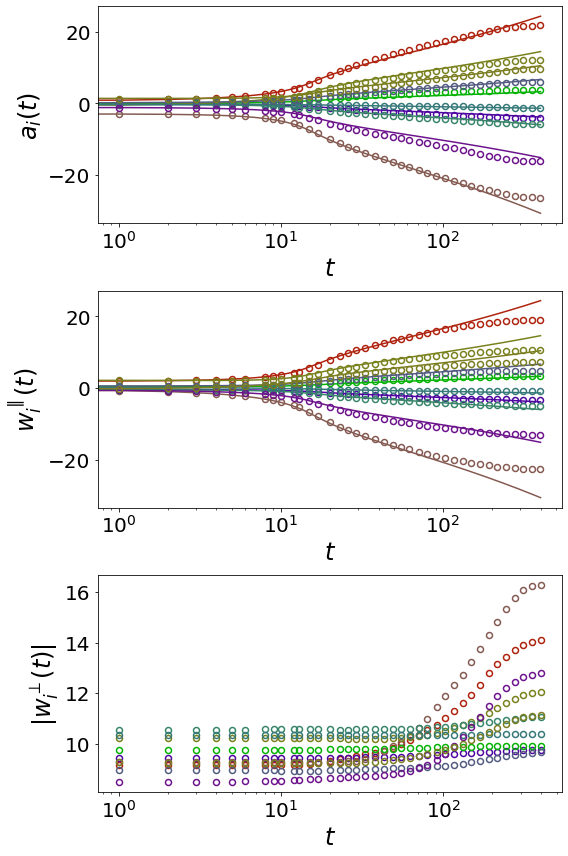

In [108]:
# Plot a, w^\parallel and w\perp
# Parameters:
Nnodes = 10   # Number of nodes to show (picked at random)
Ndots = 50  # Number of points to plot (~equally spaced in log scale)

indices = (np.exp(np.arange(Ndots)*np.log(act_num-1)/(Ndots-1))).astype(int)-1
indices = np.unique(indices)
randnodes = np.random.choice(HS,Nnodes)
rcol = np.random.random((Nnodes,3))
rcol = 0.7*rcol/np.linalg.norm(rcol, axis=1)[:, np.newaxis]

fig, ax = plt.subplots(3,1, figsize=(8, 4*3))
for i in range(3):
  ax[i].set_xscale("log")
  ax[i].set_xlabel(r"$t$", fontsize=24)
  ax[i].tick_params(labelsize=20)
ax[0].set_ylabel(r"$a_i(t)$", fontsize=24)
ax[1].set_ylabel(r"$w^\parallel_i(t)$", fontsize=24)
ax[2].set_ylabel(r"$|w^\perp_i(t)|$", fontsize=24)
for i, n in enumerate(randnodes):
  ax[0].plot(indices*act_each,(a[indices,n]),'o',mfc='none',mew=1.5,color=rcol[i])
  ax[0].plot(np.arange(steps),(a[0,n]*np.cosh(gl)+w[0,n]*np.sinh(gl)),'-',color=rcol[i])
  ax[1].plot(indices*act_each,(w[indices,n]),'o',mfc='none',mew=1.5,color=rcol[i])
  ax[1].plot(np.arange(steps),(w[0,n]*np.cosh(gl)+a[0,n]*np.sinh(gl)),'-',color=rcol[i])
  ax[2].plot(indices*act_each,(wperp[indices,n]),'o',mfc='none',mew=1.5,color=rcol[i])
plt.tight_layout()

## Visualizing parameters distribution

This code will plot the parameter distribution in $(a(t), w^\parallel(t))$ space.

The first cell will produce a figure similar to Fig.2b, ideal for the "rich learning" regime, it requires a list of steps to be plotted.

The second cell will visualize first and last configuration and the derivative at time 0 as in Fig.2a, ideal to visualize the "lazy learning" regime.

The third cell will plot again the initial evolution, with a style similar to Fig.4b. It requires a maximum step to be plotted.

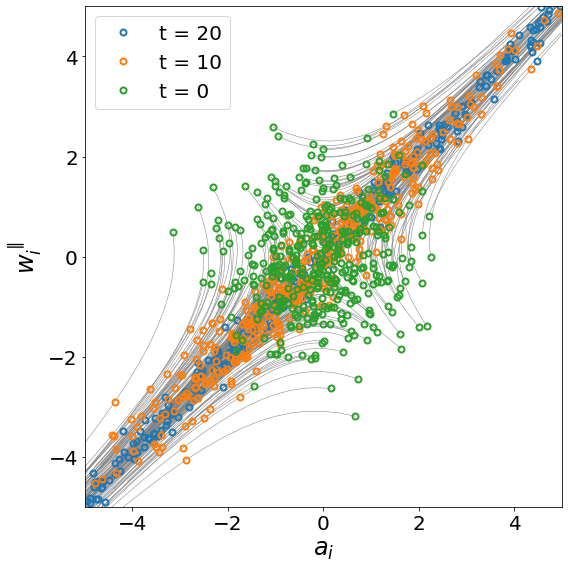

In [99]:
# Plot parameters distribution (Fig. 2b)
# Parameters
plist = [20, 10, 0] # List of timesteps to be plotted
LIM = 5  # Plot range in x and y ([-LIM, LIM])
slist = np.arange(np.max(plist))

fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.set_xlim(-LIM,LIM)
ax.set_ylim(-LIM,LIM)
ax.set_xlabel(r"$a_i$", fontsize=24)
ax.set_ylabel(r"$w^\parallel_i$", fontsize=24)
ax.tick_params(labelsize=20)
for i in range(HS):
  ax.plot(a[slist,i],w[slist,i],'-',color=(0.5,0.5,0.5),linewidth=0.5)
for i in plist:
  ax.plot(a[i],w[i],'o',mfc='none',mew=2.0,label="t = {}".format(i))
ax.legend(fontsize=20)
plt.tight_layout()

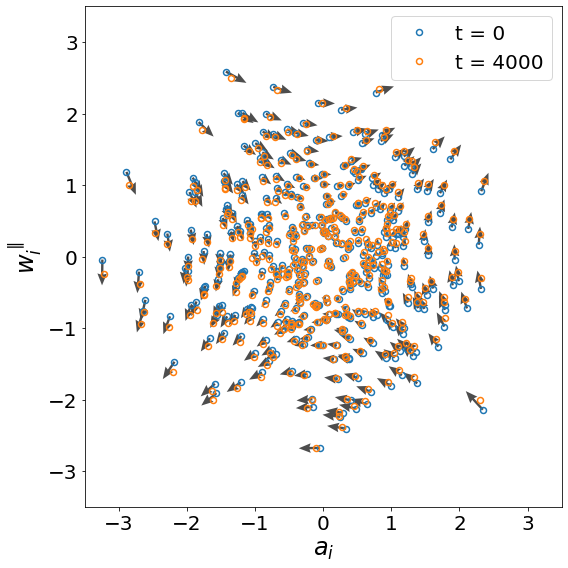

In [103]:
# Plot parameters distribution (Fig. 2a)
# Parameters
LIM = 3.5  # Plot range in x and y ([-LIM, LIM])

fig, ax = plt.subplots(1,1, figsize=(8, 8))
# a0 = wei1[0][1][:,0]
# w0 = np.sum(wei1[0][0]*w_ref,axis=0)
# a1 = wei1[act_num-1][1][:,0]
# w1 = np.sum(wei1[act_num-1][0]*w_ref,axis=0)
LIM = 3.5
ax.set_xlim(-LIM,LIM)
ax.set_ylim(-LIM,LIM)
ax.set_xlabel(r"$a_i$", fontsize=24)
ax.set_ylabel(r"$w^\parallel_i$", fontsize=24)
ax.tick_params(labelsize=20)
ax.plot(a[0],w[0],'o',mfc='none',mew=1.5,label="t = 0")
ax.plot(a[-1],w[-1],'o',mfc='none',mew=1.5,label="t = 4000")
ax.legend(fontsize=20)
ax.quiver(a[0], w[0], w[0], a[0], color=(0.3,0.3,0.3),scale=60.0,width=0.005,headwidth=4)
plt.tight_layout()

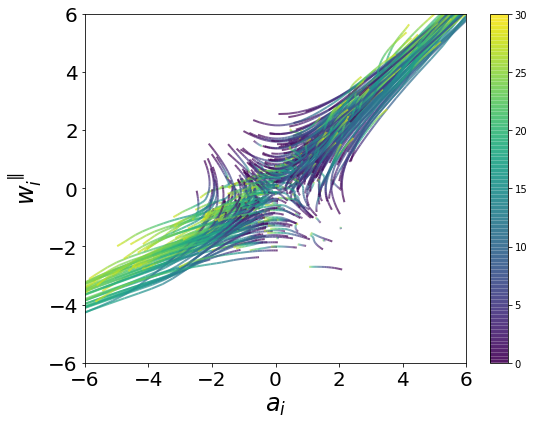

In [87]:
# Plot parameters distribution (Fig. 4b)
# Parameters
Tmax = 30  # Maximum time to be plotted
LIM = 6  # Plot range in x and y ([-LIM, LIM])
indmax = int(Tmax/act_each)

fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.set_xlim(-LIM,LIM)
ax.set_ylim(-LIM,LIM)
ax.set_xlabel(r"$a_i$", fontsize=24)
ax.set_ylabel(r"$w^\parallel_i$", fontsize=24)
ax.tick_params(labelsize=20)
for hn in range(HS):
  points = np.array([a[:indmax,hn], w[:indmax,hn]]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  times = np.arange(indmax)*act_each
  norm = plt.Normalize(0, indmax*act_each)
  lc = LineCollection(segments, cmap='viridis', norm=norm)
  lc.set_array(times)
  lc.set_linewidth(2.0)
  lc.set_alpha(0.7)
  line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)
plt.tight_layout()

## Visualizing time of satisfaction

We want to visualize the first time an example is satisfied vs its projection on the reference vector. This will produce a plot similar to that of Fig.1d.

We separate the task in 2 cells: computing the quantities and plotting them. The addition of our estimated to the plot requires that $\gamma(t)$ has been computed in the corresponding cell above.

In [0]:
# Calculation of the time when examples are satisfied
# Parameters
Nratio = 1.0  # Ratio of points to be computed and visualized (to reduce memory usage)

Npoi = int(TRAIN_SIZE*Nratio)
artr = np.asarray(ytrain1)
sattime = np.asarray([(alpha*artr[:,i]*train_set_p[i]<1.0).nonzero()[0][-1] for i in range(0, Npoi)]).flatten()
xpar = np.sum(train_set_x[:Npoi]*w_ref[np.newaxis,:,0],axis=1)

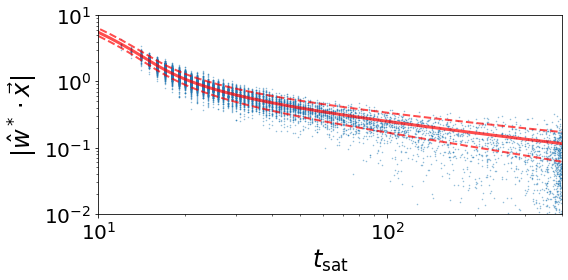

In [110]:
# Visualization of satisfaction time and projection on wref, see Fig.1d.

fig, ax = plt.subplots(1,1, figsize=(8, 4))
#Removing points still unsatisfied at end training
satrem = sattime[np.where(sattime<act_num-2)]
xrem = xpar[np.where(sattime<act_num-2)]
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-2,np.sqrt(dd))
ax.set_xlim(10,steps)
ax.set_ylabel(r"$|\hat w^*\cdot\vec x|$", fontsize=24)
ax.set_xlabel(r"$t_{\rm sat}$", fontsize=24)
ax.tick_params(labelsize=20)
ax.plot((satrem)*act_each,np.abs(xrem),'o',ms=0.5,alpha=0.5,label="Sat")

# Computing and plotting our average end error estimates
f0 = np.sinh(2*gl)/(2*np.sqrt(dd))
sigp = (5*np.cosh(2*gl)**2-3)/(4*dd*HS)
sig0 = ((dd-1)*np.cosh(2*gl))/(2*dd*HS)
ax.plot(np.arange(steps),2*np.sqrt(dd)/(alpha*np.sinh(2*gl)+1e-20),'r-',linewidth=3,alpha=0.7)
ax.plot(np.arange(steps),(f0/alpha+np.sqrt((sigp/(alpha**2))+(sig0*f0**2)-(sig0*sigp)))/(f0**2-sigp),'r--',linewidth=2,alpha=0.7)
ax.plot(np.arange(steps),(f0/alpha-np.sqrt((sigp/(alpha**2))+(sig0*f0**2)-(sig0*sigp)))/(f0**2-sigp),'r--',linewidth=2,alpha=0.7)
plt.tight_layout()

## Visualizing gradients

We want to visualize the average over the unsatisfied dataset of $y{\bf x}$ along the reference direction and perpendicular to it, and compare with our analytical estimates $I(t)$ and $J(t)/\sqrt{N}$ (see the paper for details). This will produce a plot similar to that of Fig.2b.
We also directly visualize the number of examples unsatisfied as a function of time.

We separate the task in 2 cells: computing the quantities and plotting them. The addition of our estimated to the plot requires that $\gamma(t)$ has been computed in the corresponding cell above.
This calculation can be a bit longer than the rest, for this reason we provide an option to subsample the dataset and/or the nodes.

In [5]:
# Compute the parallel and perpendicular component of gradients
# Parameters
Nratio = 0.5  # Fraction of examples to use for the estimate
Mratio = 0.5 # Fraction of nodes to use for the estimate
TPNum = 100  # Number of timesteps at which gradients are evaluated (~equally spaced in log scale)

gpal = []
gpel = []
nleft = []
artr = np.asarray(ytrain1)
mind = np.arange(int(HS*Mratio))
Neff = int(TRAIN_SIZE*Nratio)
TPNum = 100
Tpoints = (np.exp(np.arange(TPNum)*np.log(act_num-1)/(TPNum-1))).astype(int)-1
Tpoints = np.unique(Tpoints)
eTP = len(Tpoints)

for i, ii in enumerate(Tpoints):
  print("\rComputing timestep: {}/{}".format(i+1,eTP), end='')
  wt = wei1[ii][0]
  inds = (alpha*artr[ii,:Neff]*train_set_p[:Neff]<1.0).nonzero()[0]
  nleft.append(len(inds))
  wp = []
  Ivecl = []
  for hn in mind:
    thetavg = np.where(np.sum(wt[np.newaxis,:,hn]*train_set_x[inds,:],axis=1)>0,1,0)
    Ivec = np.sum(thetavg[:,np.newaxis]*train_set_x[inds,:]*train_set_p[inds,np.newaxis],axis=0)/Neff
    wp.append(np.sum(Ivec*w_ref[:,0]))
    Ivecl.append(np.linalg.norm(Ivec))
  wp = np.asarray(wp)
  Ivecl = np.asarray(Ivecl)
  gpal.append(np.mean(wp))
  gpel.append(np.mean(np.sqrt(Ivecl**2-wp**2)))

Computing timestep: 69/69

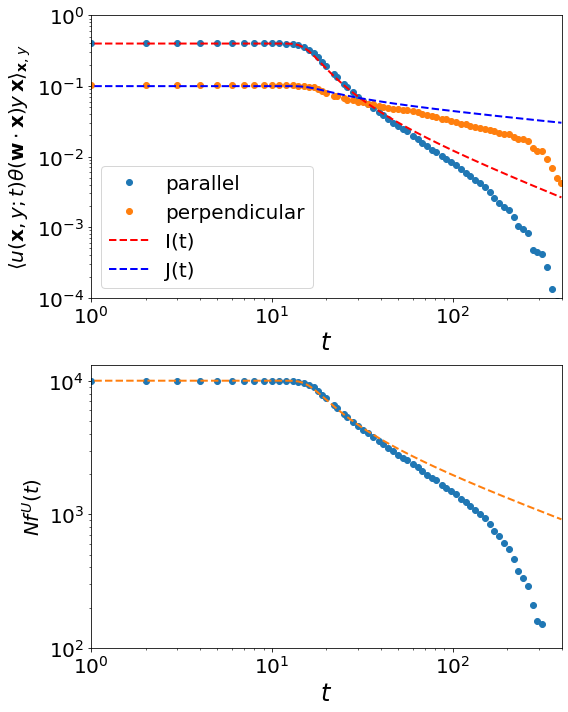

In [6]:
# Plotting parallel and perpendicular components of the gradients, 
# and our estimates I(t) and J(t)
# Also plotting the number of unsatisfied examples
eps = 1e-20  # Small quantity for numerical stability
fig, ax = plt.subplots(2,1, figsize=(8, 5*2))
for i in range(2):
  ax[i].set_xscale("log")
  ax[i].set_yscale("log")
  ax[i].set_xlim(1.0,steps)
  ax[i].set_xlabel(r"$t$", fontsize=24)
  ax[i].tick_params(labelsize=20)
ax[0].set_ylabel(r"$\left\langle u({\bf x},y;t)\theta\left({{\bf w}\cdot{\bf x}}\right)y\,{\bf x}\right\rangle_{{\bf x},y}$", fontsize=20)
ax[0].set_ylim(1e-4,1)
ax[1].set_ylabel(r"$N f^U(t)$", fontsize=20)
ax[1].set_ylim(TRAIN_SIZE*0.01,TRAIN_SIZE*1.3)

ax[0].plot(Tpoints*act_each,gpal,'o',label="parallel")
ax[0].plot(Tpoints*act_each,gpel,'o',label="perpendicular")
ax[0].plot(np.arange(steps),((1-ErrRatio)*(1-np.exp(-2*h**2*dd/((alpha**2*np.sinh(2*gl)**2)+eps)))-ErrRatio)/np.sqrt(2*np.pi),'r--',linewidth=2,label="I(t)")
ax[0].plot(np.arange(steps),np.sqrt((dd-1)*((1-ErrRatio)*special.erf(np.sqrt(2*dd)*h/(alpha*np.sinh(2*gl)+eps))+ErrRatio)/(2*Neff)),'b--',linewidth=2,label="J(t)")
ax[0].legend(fontsize=20)
ax[1].plot(Tpoints*act_each,np.asarray(nleft)/Nratio,'o')
ax[1].plot(np.arange(steps),((1-ErrRatio)*special.erf(np.sqrt(2*dd)*h/(alpha*np.sinh(2*gl)+eps))+ErrRatio)*TRAIN_SIZE,'--',linewidth=2)
plt.tight_layout()